### Callisto tket framework

The tket framework is a quantum software framework primarily used for the development and execution of quantum algorithms (quantum circuits). It is designed to be platform-agnostic software, and there are a lot of extensions available which allow tket to interface with backends from a range of providers ( see <a href="https://cqcl.github.io/pytket-extensions/api/index.html"> tket extension </a> ).

Due to its popularity and the broad amount of available backends using this framework, we wrote an extension to tket that enables a user to communicate with the C12 emulator <b> Callisto </b>. The backend name is `CallistoBackend`.

We need to create a circuit using the `Circuit` class to run a quantum algorithm.

In [11]:
from pytket import Circuit

circuit = Circuit(2)
circuit.X(0)
circuit.CX(0, 1)

print(circuit.get_commands())

[X q[0];, CX q[0], q[1];]


Internally all circuits in the pytket framework are represented as directed acyclic graphs (DAG). Using ptyket util package it is possible to see the corresponding DAG of the chosen circuit.

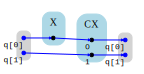

In [12]:
from pytket.utils import Graph
Graph(circuit).get_DAG()

A classical model for quantum computing is a model where the main program is run on the host computer, which occasionally sends off jobs to the quantum computer and retrieves the results. A backend represents a connection to some instance, either quantum hardware or an emulator. It presents a uniform interface for submitting circuits to be processed and retrieving the results. The main goal of this approach is to promote the development of platform-independent software, helping the code that the developers write to be more future-proof.

Using tket's abstract class, `Backend,` it is possible to set different characteristics of a device that it should represent. The main properties that a backend need to implement are:

1. The restrictions that are specific to specific quantum devices. Different constraints are encoded using the predicates, which are essentially a boolean property of a circuit that must return True to run the circuit on the target machine.

2. Sending a circuit to the target device and examining the results. This process can be accomplished by calling `Backend.process_circuit()` or `Backend.process_circuits()` methods. These methods will send a circuit for execution and return an instance of `ResultHandle` as a result of their execution. The `ResultHandle` is a unique identifier that can be used to retrieve the actual results once the job has finished.

3. Retrieval of the results. Obtaining the results of a successfully run job
 is done using the `Backend.get_result()` method, which returns an instance of `BackendResult` class. The class `BackendResult` has methods that can be useful for obtaining different pieces of information about the job that has been run. These methods are:
`get_state()` - get the state vector
`get_shots()` - get the shots. The shots are returned as a 2D array of the result for each shot.
`get_counts()` - get the counts (it is obtained from the shots directly)
`get_density_matrix()` - get the density matrix of the job.


To implement the C12 emulator Callisto, we have developed `CallistoBackend` class with all the above options incorporated.

In [3]:
import sys
sys.path.append('/Users/viktor/Desktop/Projects/c12sim-frontend/src')

In [4]:
from c12simulator_clients.pytket.extensions.callisto import CallistoBackend

access_token = "b2fdffcc-6d9e-4de1-9c57-69233cdbd3d1" # Token that is obtained for allowing the access to the system
backend_name = "c12sim-iswap"

# create callisto backend instance
callisto = CallistoBackend(backend_name, token=access_token, verbose=False)

# Get the ResultHandle instance
handle = callisto.process_circuit(circuit, n_shots=1024)
print(handle)

('15b006db-8b93-4394-a23f-8a16d6efd99b',)


In [10]:
job_uuid = handle[0]

# Get BackendResult instance
job_result = callisto.get_result(handle)


print(callisto.circuit_status(handle)) # Get the status of the circuit
print(job_result.get_shots())
print(job_result.get_counts())

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)
[[1 0]
 [1 0]
 [0 0]
 ...
 [1 1]
 [1 1]
 [1 1]]
Counter({(1, 1): 1013, (0, 1): 7, (0, 0): 2, (1, 0): 2})


In [14]:
circuit2 = Circuit(20)
for n in range(1, 20):
    circuit2.X(n)
    circuit2.CX(0, n)

handle2 = callisto.process_circuit(circuit2, n_shots=1024)

# This should fail due to MaxNQubitsPredicate which controls the number of qubits that can be run on the emulator

CircuitNotValidError: Circuit with index 0 in submitted does not satisfy MaxNQubitsPredicate(13) (try compiling with backend.get_compiled_circuits first).